# CITATION LOCATION - clustering analysis using beat number for location
Holding other variables constant and only examining for location, am I able to find areas of the city with specific types of clustering?

### IMPORT LIBRARIES AND DATA

In [15]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import glob
pd.set_option('display.max_columns', None)
sns.set(style='darkgrid')
# plt.style.use('bmh')
plt.rcParams['patch.edgecolor'] = 'none'
import jenkspy
# from yellowbrick.cluster import SilhouetteVisualizer


from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in data that has already been preprocessed
df = pd.read_csv('data/clustering_features.csv')

In [3]:
df.shape

(36626, 10)

In [4]:
df.head()

,beat,cited_person_age,citation_time,charge_description,street,month,day_of_week,hour_of_day,place_id,age_breaks
0,12.0,19.0,747,Speed Greater Than R&P or Posted,E Shea Bl,7,2,7,E Shea Bl - 6xxx,"(17.999, 24.0]"
1,12.0,36.0,800,Speed Greater Than R&P or Posted,E Shea Bl,7,2,8,E Shea Bl - 6xxx,"(30.0, 39.0]"
2,7.0,61.0,853,Speed Greater Than R&P or Posted,N Goldwater Bl,7,2,8,N Goldwater Bl - 4xxx,"(51.0, 97.0]"
3,7.0,59.0,843,Speed Greater Than R&P or Posted,N Goldwater Bl,7,3,8,N Goldwater Bl - 4xxx,"(51.0, 97.0]"
4,19.0,23.0,2215,Speed Greater Than R&P or Posted,N Pima Rd,7,5,22,N Pima Rd - 2xxx,"(17.999, 24.0]"


In [5]:
# drop place id for the time being
df.drop(['place_id'], axis=1, inplace=True)

In [6]:
# drop features I don't want to use for now

df.drop(['citation_time'], axis=1, inplace=True)
# df.drop(['age_breaks'], axis=1, inplace=True)
# df.drop(['beat'], axis=1, inplace=True)
df.drop(['age_breaks'], axis=1, inplace=True)

In [7]:
df.drop(['street'], axis=1, inplace=True)

In [8]:
# drop citations where beat is null
# otherwise this creates problems for modeling

df.drop(df[df.beat.isnull()].index, inplace=True)

In [9]:
# verify no null values remain
df.isnull().sum()

beat                  0
cited_person_age      0
charge_description    0
month                 0
day_of_week           0
hour_of_day           0
dtype: int64

In [10]:
df.head()

,beat,cited_person_age,charge_description,month,day_of_week,hour_of_day
0,12.0,19.0,Speed Greater Than R&P or Posted,7,2,7
1,12.0,36.0,Speed Greater Than R&P or Posted,7,2,8
2,7.0,61.0,Speed Greater Than R&P or Posted,7,2,8
3,7.0,59.0,Speed Greater Than R&P or Posted,7,3,8
4,19.0,23.0,Speed Greater Than R&P or Posted,7,5,22


In [11]:
# identify unique beat locations
df.hour_of_day.unique()

array([ 7,  8, 22, 23, 19, 10,  0, 20, 12, 14, 15, 17, 11, 16,  5, 18, 21,
        3,  6,  2,  9,  1, 13,  4], dtype=int64)

In [12]:
# which beats seem to be the most clustered?
sil_score = []
cluster_count = []

for hour in list(df.hour_of_day.unique()):
    
    df2 = df[df.hour_of_day == hour]
    X = pd.get_dummies(df2.drop(['hour_of_day'], axis=1))
    
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=.7, min_samples=20)

    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    
    # capture cluster count
    cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))

    # capture model fit
    if pd.Series(clusters).nunique() > 1:
        sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
    else:
        sil_score.append(np.nan)

### Which beats seem the most clustered?

In [13]:
cluster_scores = pd.DataFrame(list(zip(list(df.beat.unique()), sil_score, cluster_count)),
             columns=['hour', 'sil_score', 'cluster_count']) \
        .set_index('hour') \
        .sort_values(by=['sil_score', 'cluster_count'], ascending=False)

cluster_scores

,sil_score,cluster_count
hour,,
7.0,0.200,1
2.0,0.126,1
9.0,0.001,2
8.0,-0.068,1
5.0,-0.103,1
10.0,-0.104,4
11.0,-0.106,4
12.0,-0.124,3
1.0,-0.135,1


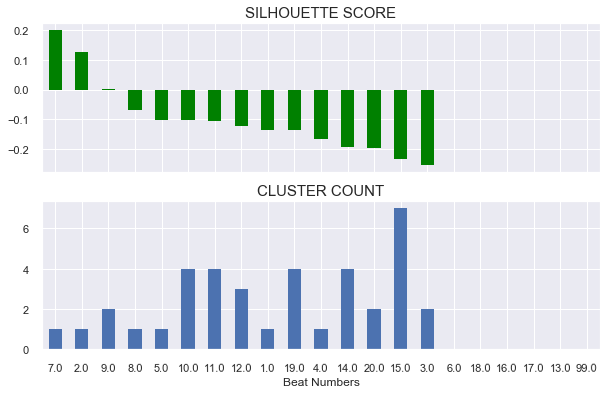

In [16]:
# plot silhouette score and cluster count
fig, (ax0, ax1) = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(10, 6))

cluster_scores.loc[:,['sil_score']] \
    .plot(kind='bar', color='green', legend=False, ax=ax0)
ax0.set_title('SILHOUETTE SCORE', fontsize=15)


cluster_scores.loc[:,['cluster_count']] \
    .plot(kind='bar', legend=False, ax=ax1);
ax1.set_title('CLUSTER COUNT', fontsize=15)

plt.xlabel('Beat Numbers')
plt.xticks(rotation=1);

Beat 6 seems to show the tightest clustering based on silhouette score.

## 11 AM

In [52]:
hour = 11

In [53]:
subset_df = df[df.hour_of_day == hour]

In [54]:
X = pd.get_dummies(subset_df)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [55]:
# find best DBSCAN parameters
cluster_count = []
sil_score = []
eps_ = []
min_samples_ = []

for eps in [.1, .5, 1, 5, 10]:
    for min_samples in [5, 10, 25, 50]:
    
        # Defining the agglomerative clustering
        dbscan_cluster = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit model
        clusters = dbscan_cluster.fit_predict(X_std)
        
        # capture cluster count
        cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))
        
        # capture model fit
        if pd.Series(clusters).nunique() > 1:
            sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
        else:
            sil_score.append(np.nan)
        
        # record parameter values
        eps_.append(eps)
        min_samples_.append(min_samples)

In [56]:
# tabulate param results from above
# sort by silhouette score & cluster count
pd.DataFrame(list(list(zip(sil_score, cluster_count, eps_, min_samples_))), 
            columns=['sil_score', 'cluster_count', 'eps', 'min_samples']) \
        .sort_values(by=['sil_score', 'cluster_count'], ascending=False)

,sil_score,cluster_count,eps,min_samples
16,0.616,2,10.0,5
17,0.616,2,10.0,10
18,0.616,1,10.0,25
19,0.616,1,10.0,50
12,0.300,5,5.0,5
13,0.300,5,5.0,10
8,0.296,22,1.0,5
14,0.290,3,5.0,25
15,0.290,3,5.0,50
9,0.197,8,1.0,10


## Model best parameters from above

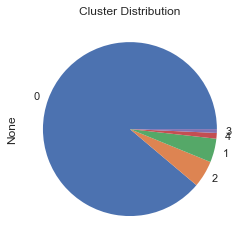

In [57]:
dbscan_cluster = DBSCAN(eps=5, min_samples=5)
clusters = dbscan_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution');

In [74]:
pd.Series(clusters).value_counts(dropna=False)

0    1251
2      70
1      62
4      15
3      10
dtype: int64

In [59]:
# format beat 6 data for plotting
subset_df = pd.concat([subset_df.reset_index(drop=True), pd.Series(clusters).rename('cluster')], axis=1)

In [60]:
subset_df = subset_df[subset_df.cluster != -1]

In [61]:
subset_df

,beat,cited_person_age,charge_description,month,day_of_week,hour_of_day,cluster
0,17.0,22.0,Failure to Control Speed to Avoid A Collision,7,5,11,0
1,10.0,38.0,Expired/No Arizona Registration,7,2,11,0
2,11.0,37.0,Expired/No Arizona Registration,7,1,11,0
3,12.0,23.0,Speed Greater Than R&P or Posted,7,2,11,0
4,6.0,27.0,Suspended/Revoked D.L.,7,1,11,0
...,...,...,...,...,...,...,...
1403,14.0,54.0,Failure to Control Speed to Avoid A Collision,10,1,11,0
1404,19.0,58.0,Speed Greater Than R&P or Posted,9,3,11,0
1405,12.0,26.0,Suspended/Revoked D.L.,10,2,11,0
1406,15.0,40.0,No Proof of Insurance,9,3,11,1


In [76]:
subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['cited_person_age']]

cited_person_age
                                                                  mean
cluster charge_description                                            
0       Expired/No Arizona Registration                      38.725869
        Fail to Obey Traffic Control Device                  41.891304
        Fail to Stop For Red Signal                          47.112500
        Fail to Stop at Stop Sign                            49.065789
        Failure to Control Speed to Avoid A Collision        45.419890
        Speed Greater Than R&P or Posted                     42.950588
        Suspended/Revoked D.L.                               35.804348
1       No Proof of Insurance                                43.532258
2       Drug Paraphernalia-Possess/Use                       32.242857
3       DUI-Impaired to Slightest Degree                     41.600000
4       Expired/No Arizona Registration                      29.000000
        Fail to Obey Traffic Control Device                  35.000000
        Failure to Control Speed to Avoid A Collision        36.000000
        Speed Greater Than R&P or Posted                     40.142857

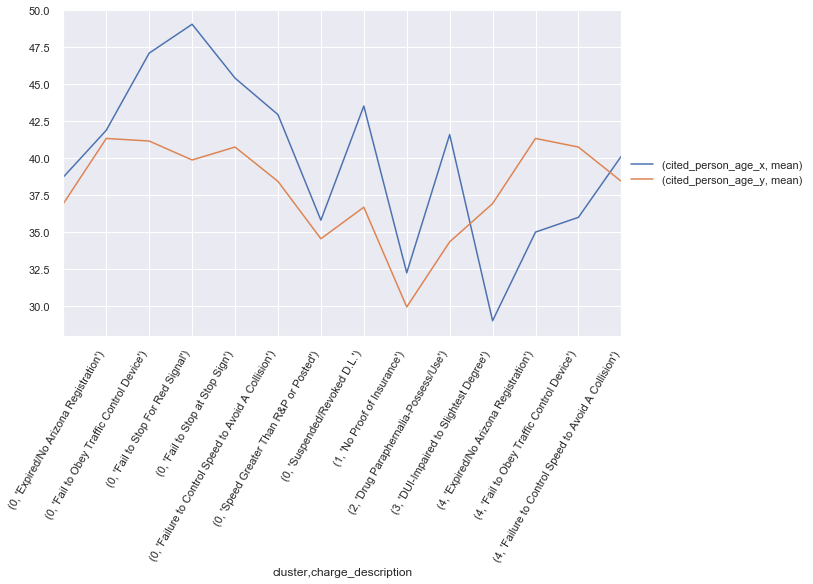

In [179]:
# fig, plt.subplots(figsize=(12, 6))

fig, ax = plt.subplots(figsize=(10, 6))

subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['cited_person_age']].reset_index().merge(
df.groupby(['charge_description']).agg(['mean']).loc[:,['cited_person_age']].reset_index(),
how='left',
on='charge_description').set_index(['cluster', 'charge_description']).plot(ax=ax)

plt.legend(loc='center left', bbox_to_anchor=(1.0, .5))

# plt.xticks()
# .plot()

ax.set_xticks(range(1, len(list(subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['cited_person_age']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['cited_person_age']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index)),1))

ax.set_xticklabels(list(subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['cited_person_age']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['cited_person_age']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index))

plt.xticks(rotation=60, horizontalalignment="right");

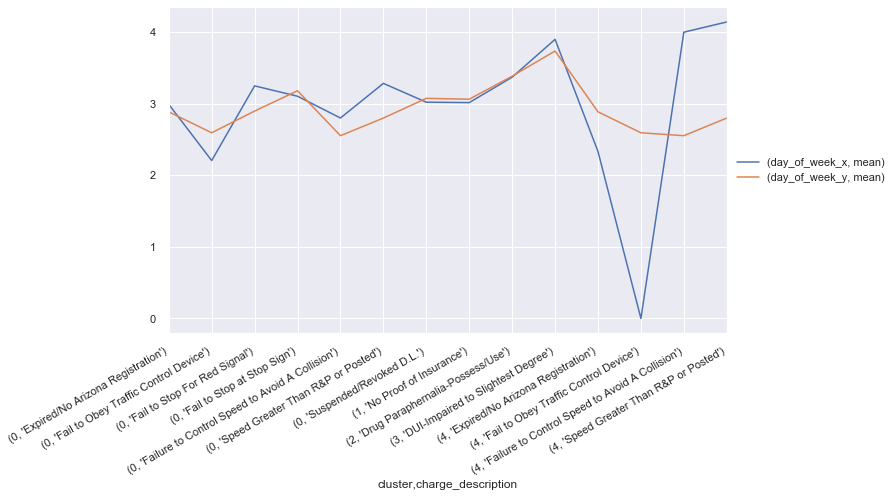

In [185]:
fig, ax = plt.subplots(figsize=(10, 6))

subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['day_of_week']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['day_of_week']].reset_index(),
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).plot(ax=ax)

plt.legend(loc='center left', bbox_to_anchor=(1.0, .5))


ax.set_xticks(range(0, len(list(subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['day_of_week']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['day_of_week']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index)),1))

ax.set_xticklabels(list(subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['day_of_week']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['day_of_week']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index))

plt.xticks(rotation=30, horizontalalignment="right");

### PCA

In [354]:
# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

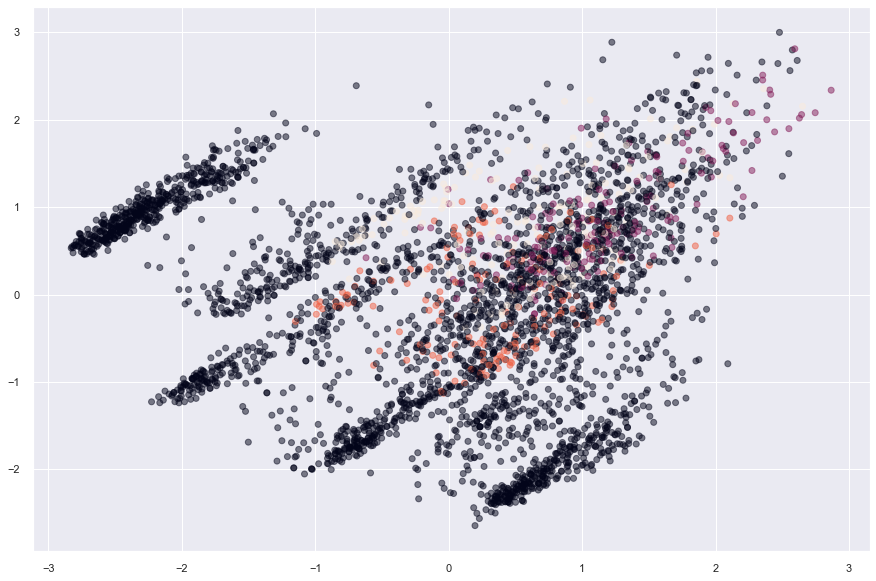

In [355]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.Series(clusters), alpha=.5);

### t-SNE

In [356]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3574 samples in 0.005s...
[t-SNE] Computed neighbors for 3574 samples in 0.397s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3574
[t-SNE] Computed conditional probabilities for sample 2000 / 3574
[t-SNE] Computed conditional probabilities for sample 3000 / 3574
[t-SNE] Computed conditional probabilities for sample 3574 / 3574
[t-SNE] Mean sigma: 0.677984
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.336636
[t-SNE] KL divergence after 300 iterations: 1.234760


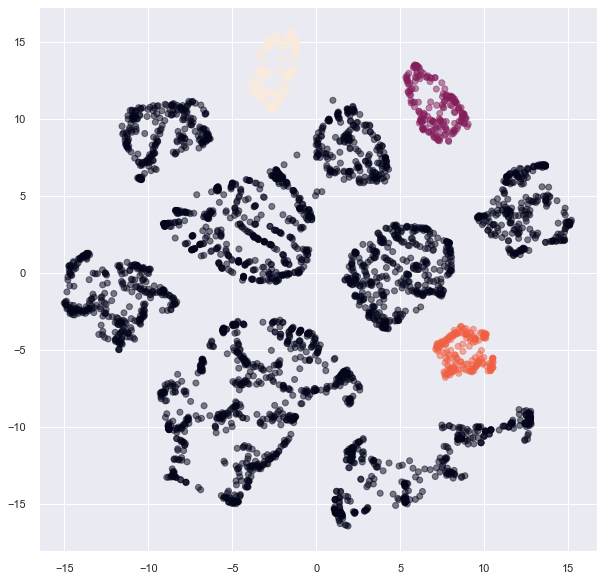

In [357]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.5, c=pd.Series(clusters));

### UMAP - iteration 1

In [ ]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

In [ ]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.5, c=pd.Series(clusters));

## 19:00

In [186]:
hour = 19

In [187]:
subset_df = df[df.hour_of_day == hour]

In [188]:
X = pd.get_dummies(subset_df)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [189]:
# find best DBSCAN parameters
cluster_count = []
sil_score = []
eps_ = []
min_samples_ = []

for eps in [.1, .5, 1, 5, 10]:
    for min_samples in [5, 10, 25, 50]:
    
        # Defining the agglomerative clustering
        dbscan_cluster = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit model
        clusters = dbscan_cluster.fit_predict(X_std)
        
        # capture cluster count
        cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))
        
        # capture model fit
        if pd.Series(clusters).nunique() > 1:
            sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
        else:
            sil_score.append(np.nan)
        
        # record parameter values
        eps_.append(eps)
        min_samples_.append(min_samples)

In [190]:
# tabulate param results from above
# sort by silhouette score & cluster count
pd.DataFrame(list(list(zip(sil_score, cluster_count, eps_, min_samples_))), 
            columns=['sil_score', 'cluster_count', 'eps', 'min_samples']) \
        .sort_values(by=['sil_score', 'cluster_count'], ascending=False)

,sil_score,cluster_count,eps,min_samples
8,0.299,16,1.0,5
14,0.294,4,5.0,25
12,0.292,5,5.0,5
13,0.291,5,5.0,10
15,0.279,3,5.0,50
9,0.088,13,1.0,10
10,-0.073,2,1.0,25
4,-0.338,13,0.5,5
16,NaN,1,10.0,5
17,NaN,1,10.0,10


## Model best parameters from above

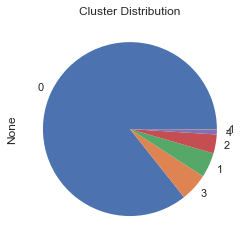

In [191]:
dbscan_cluster = DBSCAN(eps=5, min_samples=5)
clusters = dbscan_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution');

In [192]:
pd.Series(clusters).value_counts(dropna=False)

 0    1119
 3      68
 1      60
 2      46
 4      12
-1       1
dtype: int64

In [193]:
# format beat 6 data for plotting
subset_df = pd.concat([subset_df.reset_index(drop=True), pd.Series(clusters).rename('cluster')], axis=1)

In [194]:
subset_df = subset_df[subset_df.cluster != -1]

In [195]:
subset_df

,beat,cited_person_age,charge_description,month,day_of_week,hour_of_day,cluster
0,19.0,66.0,Speed Greater Than R&P or Posted,7,5,19,0
1,11.0,55.0,Expired/No Arizona Registration,7,4,19,0
2,10.0,31.0,Speed Greater Than R&P or Posted,7,5,19,0
3,6.0,24.0,Fail to Stop at Stop Sign,7,0,19,0
4,3.0,34.0,No Proof of Insurance,7,6,19,0
...,...,...,...,...,...,...,...
1301,13.0,36.0,Expired/No Arizona Registration,9,3,19,0
1302,9.0,25.0,Speed Greater Than R&P or Posted,9,2,19,0
1303,5.0,29.0,Fail to Stop at Stop Sign,9,5,19,0
1304,5.0,22.0,Fail to Stop at Stop Sign,9,5,19,0


In [196]:
subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['cited_person_age']]

cited_person_age
                                                                  mean
cluster charge_description                                            
0       DUI-Impaired to Slightest Degree                     41.097345
        Drug Paraphernalia-Possess/Use                       31.704762
        Expired/No Arizona Registration                      37.036697
        Fail to Stop at Stop Sign                            36.554545
        No Proof of Insurance                                36.343137
        Speed Greater Than R&P or Posted                     36.644377
        Suspended/Revoked D.L.                               36.908451
1       Fail to Stop For Red Signal                          35.950000
2       Fail to Obey Traffic Control Device                  37.891304
3       Failure to Control Speed to Avoid A Collision        37.691176
4       Drug Paraphernalia-Possess/Use                       21.000000
        Expired/No Arizona Registration                      33.000000
        No Proof of Insurance                                25.333333
        Speed Greater Than R&P or Posted                     33.500000
        Suspended/Revoked D.L.                               29.000000

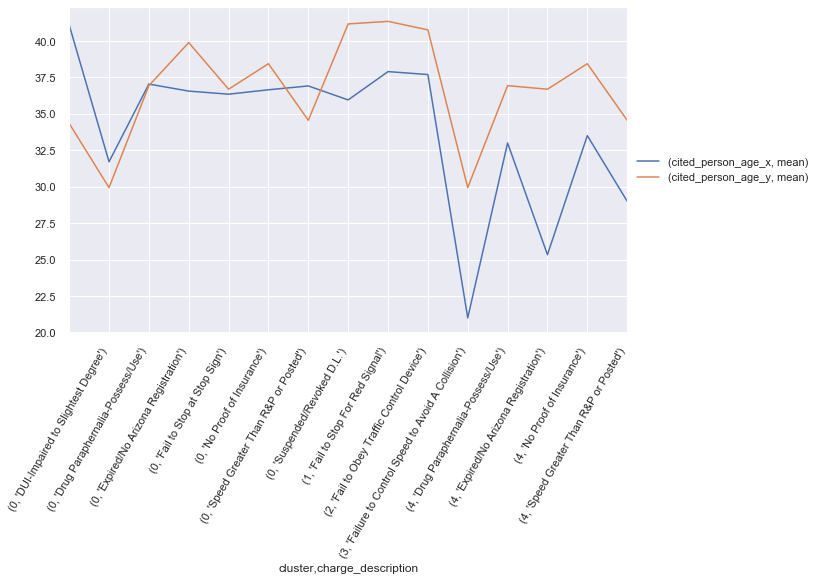

In [197]:
# fig, plt.subplots(figsize=(12, 6))

fig, ax = plt.subplots(figsize=(10, 6))

subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['cited_person_age']].reset_index().merge(
df.groupby(['charge_description']).agg(['mean']).loc[:,['cited_person_age']].reset_index(),
how='left',
on='charge_description').set_index(['cluster', 'charge_description']).plot(ax=ax)

plt.legend(loc='center left', bbox_to_anchor=(1.0, .5))

# plt.xticks()
# .plot()

ax.set_xticks(range(1, len(list(subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['cited_person_age']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['cited_person_age']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index)),1))

ax.set_xticklabels(list(subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['cited_person_age']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['cited_person_age']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index))

plt.xticks(rotation=60, horizontalalignment="right");

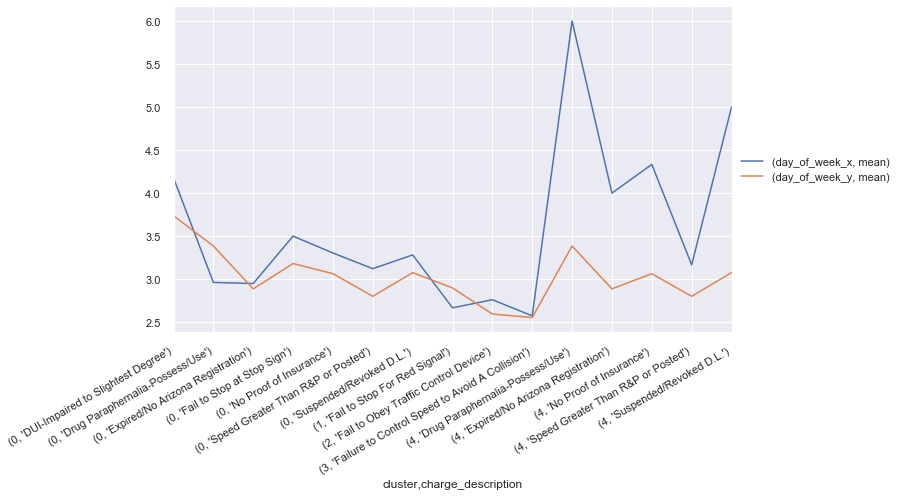

In [198]:
fig, ax = plt.subplots(figsize=(10, 6))

subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['day_of_week']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['day_of_week']].reset_index(),
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).plot(ax=ax)

plt.legend(loc='center left', bbox_to_anchor=(1.0, .5))


ax.set_xticks(range(0, len(list(subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['day_of_week']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['day_of_week']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index)),1))

ax.set_xticklabels(list(subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['day_of_week']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['day_of_week']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index))

plt.xticks(rotation=30, horizontalalignment="right");

### PCA

In [199]:
# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

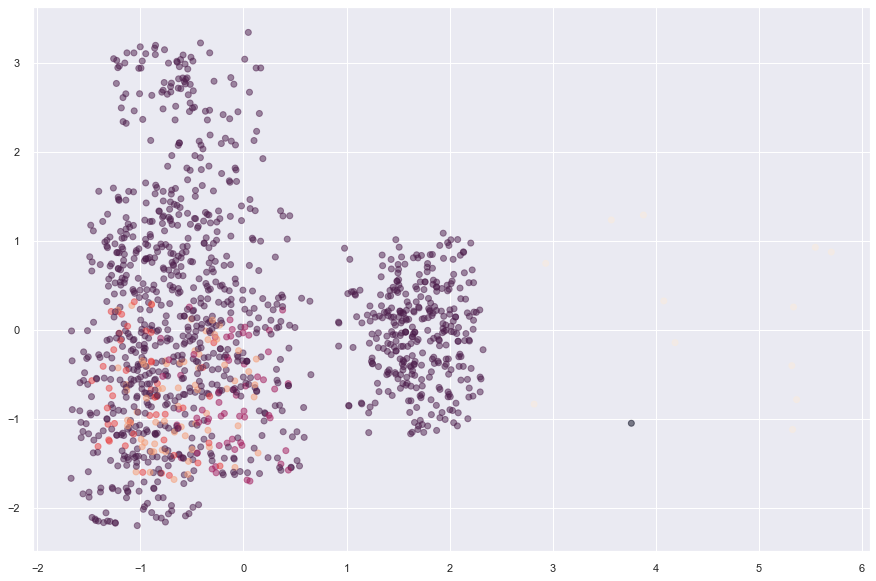

In [200]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.Series(clusters), alpha=.5);

### t-SNE

In [201]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1306 samples in 0.002s...
[t-SNE] Computed neighbors for 1306 samples in 0.092s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1306
[t-SNE] Computed conditional probabilities for sample 1306 / 1306
[t-SNE] Mean sigma: 0.965429
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.008999
[t-SNE] KL divergence after 300 iterations: 0.635752


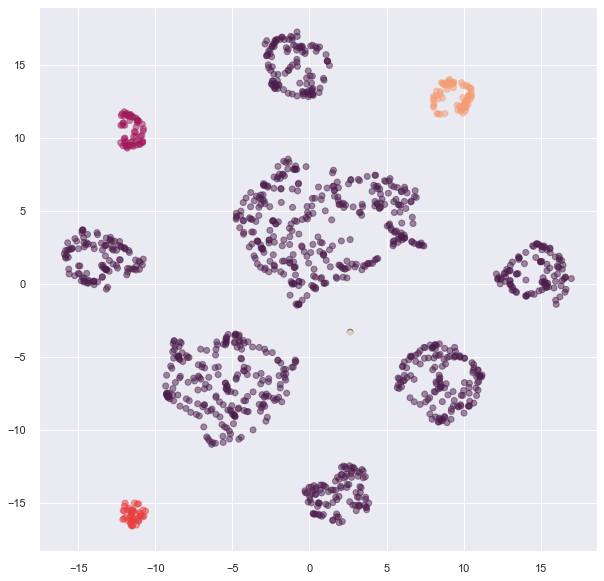

In [202]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.5, c=pd.Series(clusters));

### UMAP - iteration 1

In [203]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

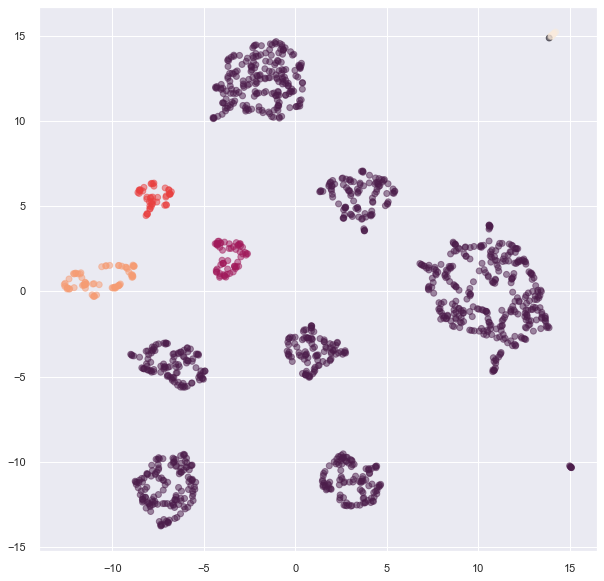

In [204]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.5, c=pd.Series(clusters));

## 9 AM

In [205]:
hour = 9

In [206]:
subset_df = df[df.hour_of_day == hour]

In [207]:
X = pd.get_dummies(subset_df)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [208]:
# find best DBSCAN parameters
cluster_count = []
sil_score = []
eps_ = []
min_samples_ = []

for eps in [.1, .5, 1, 5, 10]:
    for min_samples in [5, 10, 25, 50]:
    
        # Defining the agglomerative clustering
        dbscan_cluster = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit model
        clusters = dbscan_cluster.fit_predict(X_std)
        
        # capture cluster count
        cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))
        
        # capture model fit
        if pd.Series(clusters).nunique() > 1:
            sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
        else:
            sil_score.append(np.nan)
        
        # record parameter values
        eps_.append(eps)
        min_samples_.append(min_samples)

In [209]:
# tabulate param results from above
# sort by silhouette score & cluster count
pd.DataFrame(list(list(zip(sil_score, cluster_count, eps_, min_samples_))), 
            columns=['sil_score', 'cluster_count', 'eps', 'min_samples']) \
        .sort_values(by=['sil_score', 'cluster_count'], ascending=False)

,sil_score,cluster_count,eps,min_samples
16,0.687,2,10.0,5
17,0.687,2,10.0,10
18,0.687,1,10.0,25
19,0.687,1,10.0,50
12,0.411,7,5.0,5
13,0.411,7,5.0,10
14,0.406,5,5.0,25
15,0.406,5,5.0,50
8,0.377,15,1.0,5
9,0.242,14,1.0,10


## Model best parameters from above

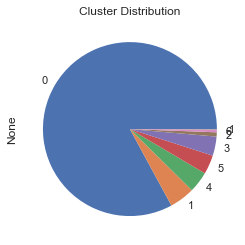

In [210]:
dbscan_cluster = DBSCAN(eps=5, min_samples=5)
clusters = dbscan_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution');

In [211]:
pd.Series(clusters).value_counts(dropna=False)

 0    1679
 1      95
 4      79
 5      72
 3      72
 2      16
 6      10
-1       2
dtype: int64

In [212]:
# format beat 6 data for plotting
subset_df = pd.concat([subset_df.reset_index(drop=True), pd.Series(clusters).rename('cluster')], axis=1)

In [213]:
subset_df = subset_df[subset_df.cluster != -1]

In [214]:
subset_df

,beat,cited_person_age,charge_description,month,day_of_week,hour_of_day,cluster
0,18.0,41.0,Speed Greater Than R&P or Posted,7,1,9,0
1,1.0,64.0,No Proof of Insurance,7,3,9,1
2,14.0,47.0,Speed Greater Than R&P or Posted,7,0,9,0
3,99.0,61.0,Failure to Control Speed to Avoid A Collision,7,1,9,2
4,15.0,70.0,Fail to Obey Traffic Control Device,7,3,9,0
...,...,...,...,...,...,...,...
2020,10.0,21.0,Speed Greater Than R&P or Posted,9,2,9,0
2021,20.0,80.0,Speed Greater Than R&P or Posted,9,2,9,0
2022,1.0,66.0,Fail to Stop For Red Signal,9,3,9,3
2023,20.0,76.0,Failure to Control Speed to Avoid A Collision,10,2,9,0


In [215]:
subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['cited_person_age']]

cited_person_age
                                                                  mean
cluster charge_description                                            
0       Expired/No Arizona Registration                      39.929936
        Fail to Obey Traffic Control Device                  45.171429
        Failure to Control Speed to Avoid A Collision        42.543307
        Speed Greater Than R&P or Posted                     40.155158
        Suspended/Revoked D.L.                               36.000000
1       No Proof of Insurance                                41.347368
2       Expired/No Arizona Registration                      35.750000
        Failure to Control Speed to Avoid A Collision        47.000000
        Speed Greater Than R&P or Posted                     40.428571
        Suspended/Revoked D.L.                               33.333333
3       Fail to Stop For Red Signal                          45.597222
4       Drug Paraphernalia-Possess/Use                       30.303797
5       Fail to Stop at Stop Sign                            43.458333
6       DUI-Impaired to Slightest Degree                     35.300000

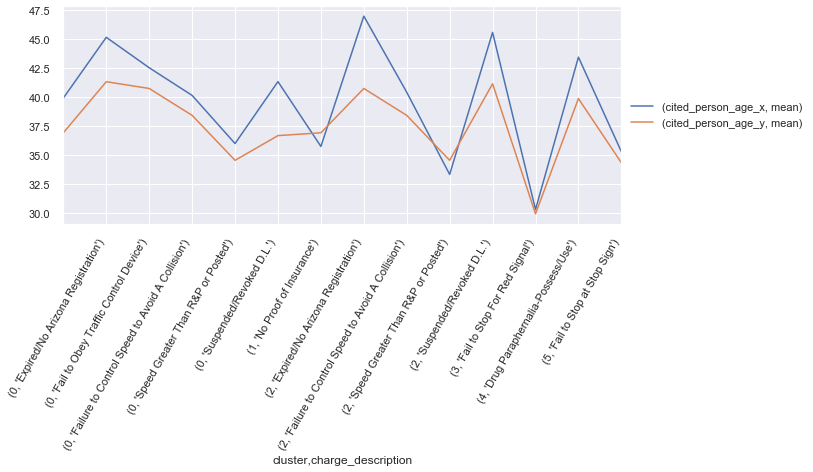

In [224]:
# fig, plt.subplots(figsize=(12, 6))

fig, ax = plt.subplots(figsize=(10, 4))

subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['cited_person_age']].reset_index().merge(
df.groupby(['charge_description']).agg(['mean']).loc[:,['cited_person_age']].reset_index(),
how='left',
on='charge_description').set_index(['cluster', 'charge_description']).plot(ax=ax)

plt.legend(loc='center left', bbox_to_anchor=(1.0, .5))

# plt.xticks()
# .plot()

ax.set_xticks(range(1, len(list(subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['cited_person_age']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['cited_person_age']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index)),1))

ax.set_xticklabels(list(subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['cited_person_age']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['cited_person_age']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index))

plt.xticks(rotation=60, horizontalalignment="right");

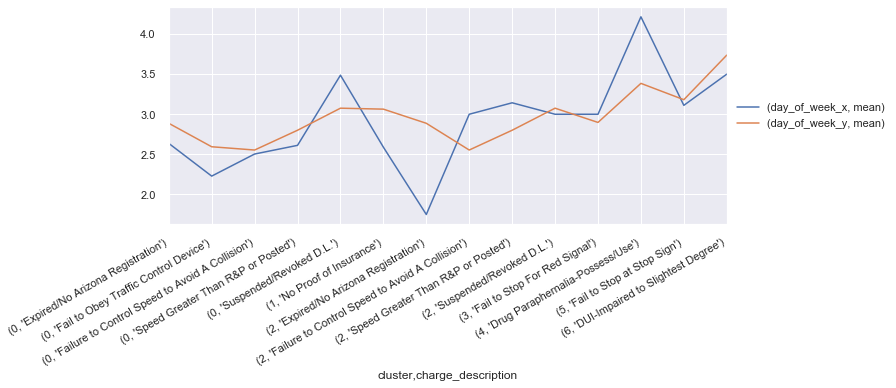

In [225]:
fig, ax = plt.subplots(figsize=(10, 4))

subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['day_of_week']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['day_of_week']].reset_index(),
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).plot(ax=ax)

plt.legend(loc='center left', bbox_to_anchor=(1.0, .5))


ax.set_xticks(range(0, len(list(subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['day_of_week']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['day_of_week']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index)),1))

ax.set_xticklabels(list(subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['day_of_week']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['day_of_week']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index))

plt.xticks(rotation=30, horizontalalignment="right");

### PCA

In [218]:
# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

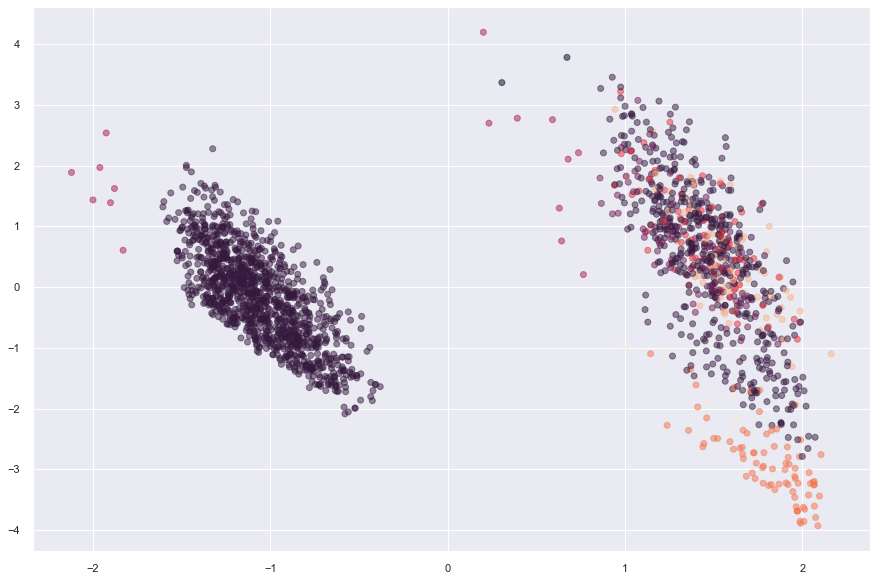

In [219]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.Series(clusters), alpha=.5);

### t-SNE

In [220]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2025 samples in 0.005s...
[t-SNE] Computed neighbors for 2025 samples in 0.186s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2025
[t-SNE] Computed conditional probabilities for sample 2000 / 2025
[t-SNE] Computed conditional probabilities for sample 2025 / 2025
[t-SNE] Mean sigma: 0.619249
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.091625
[t-SNE] KL divergence after 300 iterations: 1.007833


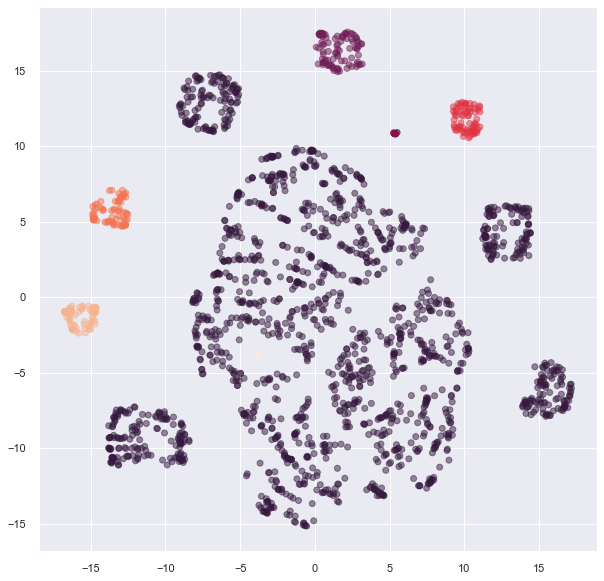

In [221]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.5, c=pd.Series(clusters));

### UMAP - iteration 1

In [222]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

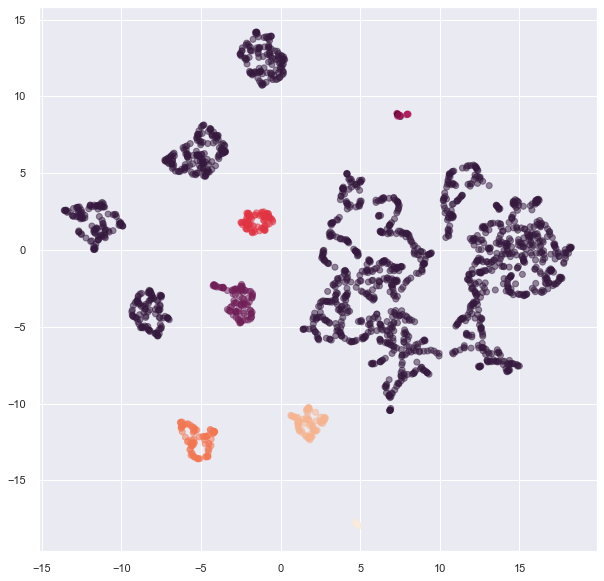

In [223]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.5, c=pd.Series(clusters));

## 14:00

In [226]:
hour = 14

In [227]:
subset_df = df[df.hour_of_day == hour]

In [228]:
X = pd.get_dummies(subset_df)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [229]:
# find best DBSCAN parameters
cluster_count = []
sil_score = []
eps_ = []
min_samples_ = []

for eps in [.1, .5, 1, 5, 10]:
    for min_samples in [5, 10, 25, 50]:
    
        # Defining the agglomerative clustering
        dbscan_cluster = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit model
        clusters = dbscan_cluster.fit_predict(X_std)
        
        # capture cluster count
        cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))
        
        # capture model fit
        if pd.Series(clusters).nunique() > 1:
            sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
        else:
            sil_score.append(np.nan)
        
        # record parameter values
        eps_.append(eps)
        min_samples_.append(min_samples)

In [230]:
# tabulate param results from above
# sort by silhouette score & cluster count
pd.DataFrame(list(list(zip(sil_score, cluster_count, eps_, min_samples_))), 
            columns=['sil_score', 'cluster_count', 'eps', 'min_samples']) \
        .sort_values(by=['sil_score', 'cluster_count'], ascending=False)

,sil_score,cluster_count,eps,min_samples
16,0.558,2,10.0,5
17,0.558,2,10.0,10
18,0.558,1,10.0,25
19,0.558,1,10.0,50
8,0.380,12,1.0,5
12,0.311,5,5.0,5
13,0.311,5,5.0,10
14,0.304,3,5.0,25
15,0.304,3,5.0,50
9,0.290,13,1.0,10


## Model best parameters from above

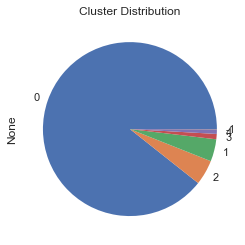

In [231]:
dbscan_cluster = DBSCAN(eps=5, min_samples=5)
clusters = dbscan_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution');

In [232]:
pd.Series(clusters).value_counts(dropna=False)

 0    1903
 2      99
 1      88
 3      21
 4      18
-1       1
dtype: int64

In [233]:
# format beat 6 data for plotting
subset_df = pd.concat([subset_df.reset_index(drop=True), pd.Series(clusters).rename('cluster')], axis=1)

In [234]:
subset_df = subset_df[subset_df.cluster != -1]

In [235]:
subset_df

,beat,cited_person_age,charge_description,month,day_of_week,hour_of_day,cluster
0,7.0,27.0,Expired/No Arizona Registration,7,0,14,0
1,18.0,21.0,Suspended/Revoked D.L.,7,0,14,0
2,15.0,43.0,Drug Paraphernalia-Possess/Use,7,5,14,1
3,19.0,29.0,Failure to Control Speed to Avoid A Collision,7,6,14,0
4,17.0,27.0,Fail to Stop For Red Signal,7,5,14,2
...,...,...,...,...,...,...,...
2125,12.0,18.0,Speed Greater Than R&P or Posted,9,4,14,0
2126,15.0,51.0,Speed Greater Than R&P or Posted,10,0,14,0
2127,2.0,52.0,Expired/No Arizona Registration,9,6,14,0
2128,1.0,20.0,Expired/No Arizona Registration,9,6,14,0


In [236]:
subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['cited_person_age']]

cited_person_age
                                                                  mean
cluster charge_description                                            
0       Expired/No Arizona Registration                      38.610922
        Fail to Obey Traffic Control Device                  43.673913
        Fail to Stop at Stop Sign                            43.106557
        Failure to Control Speed to Avoid A Collision        41.387352
        No Proof of Insurance                                39.991525
        Speed Greater Than R&P or Posted                     39.989305
        Suspended/Revoked D.L.                               37.264865
1       Drug Paraphernalia-Possess/Use                       32.613636
2       Fail to Stop For Red Signal                          48.222222
3       DUI-Impaired to Slightest Degree                     41.714286
4       Expired/No Arizona Registration                      27.000000
        Failure to Control Speed to Avoid A Collision        59.666667
        No Proof of Insurance                                22.333333
        Speed Greater Than R&P or Posted                     31.166667
        Suspended/Revoked D.L.                               30.000000

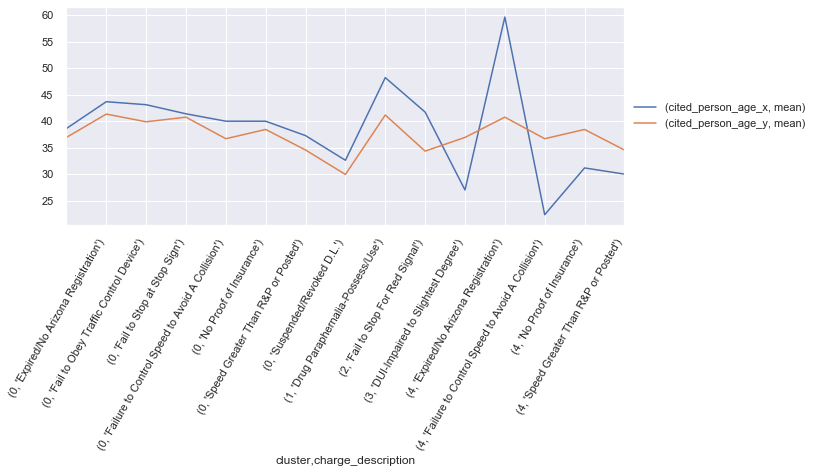

In [237]:
# fig, plt.subplots(figsize=(12, 6))

fig, ax = plt.subplots(figsize=(10, 4))

subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['cited_person_age']].reset_index().merge(
df.groupby(['charge_description']).agg(['mean']).loc[:,['cited_person_age']].reset_index(),
how='left',
on='charge_description').set_index(['cluster', 'charge_description']).plot(ax=ax)

plt.legend(loc='center left', bbox_to_anchor=(1.0, .5))

# plt.xticks()
# .plot()

ax.set_xticks(range(1, len(list(subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['cited_person_age']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['cited_person_age']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index)),1))

ax.set_xticklabels(list(subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['cited_person_age']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['cited_person_age']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index))

plt.xticks(rotation=60, horizontalalignment="right");

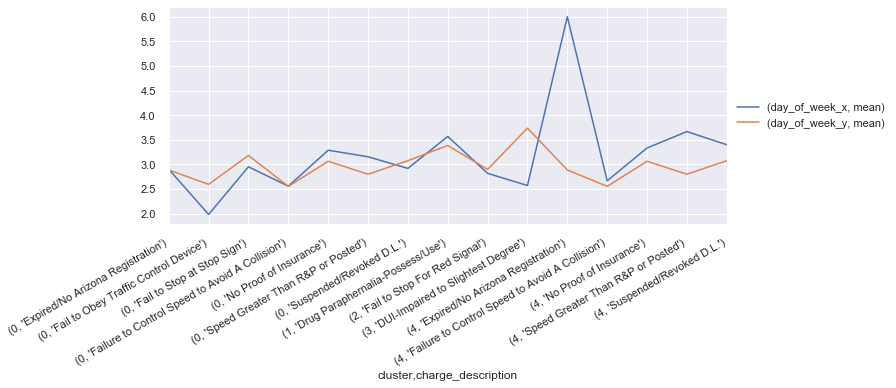

In [238]:
fig, ax = plt.subplots(figsize=(10, 4))

subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['day_of_week']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['day_of_week']].reset_index(),
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).plot(ax=ax)

plt.legend(loc='center left', bbox_to_anchor=(1.0, .5))


ax.set_xticks(range(0, len(list(subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['day_of_week']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['day_of_week']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index)),1))

ax.set_xticklabels(list(subset_df.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['day_of_week']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['day_of_week']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index))

plt.xticks(rotation=30, horizontalalignment="right");

### PCA

In [239]:
# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

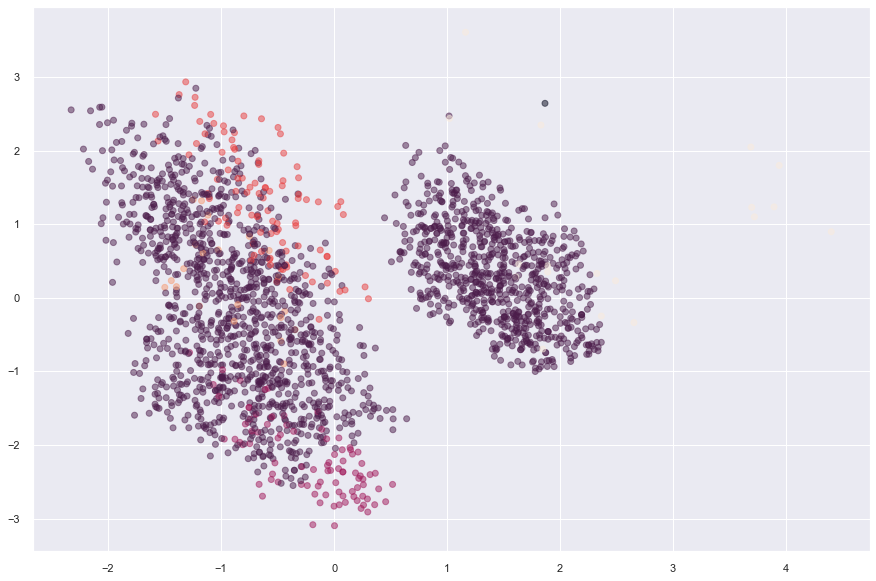

In [240]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.Series(clusters), alpha=.5);

### t-SNE

In [241]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2130 samples in 0.005s...
[t-SNE] Computed neighbors for 2130 samples in 0.193s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2130
[t-SNE] Computed conditional probabilities for sample 2000 / 2130
[t-SNE] Computed conditional probabilities for sample 2130 / 2130
[t-SNE] Mean sigma: 0.756207
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.877163
[t-SNE] KL divergence after 300 iterations: 0.966894


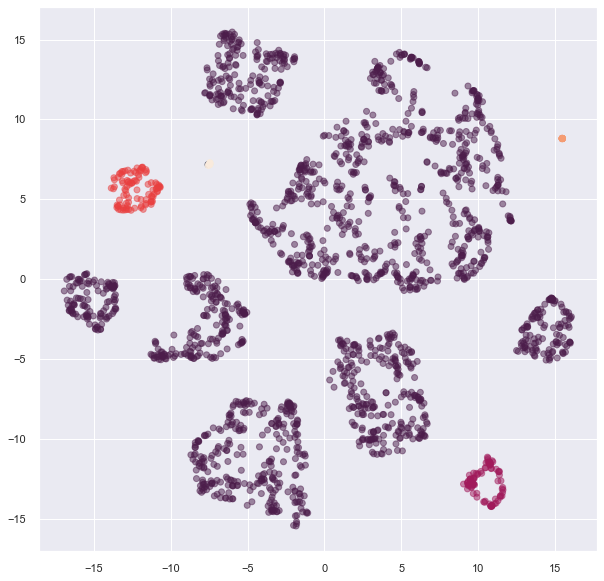

In [242]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.5, c=pd.Series(clusters));

### UMAP - iteration 1

In [243]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

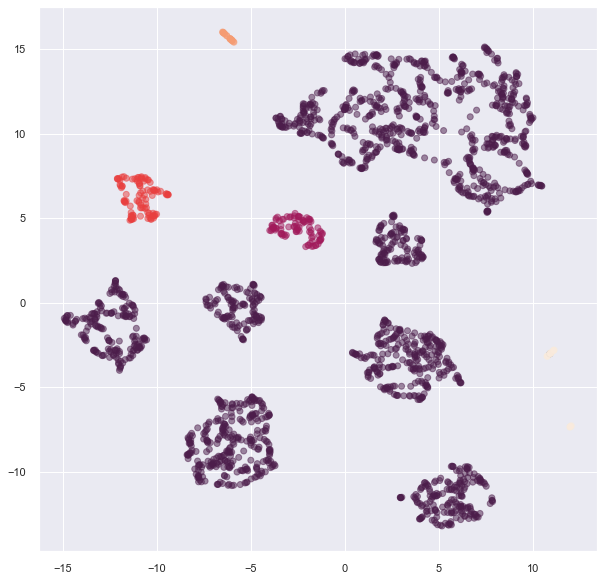

In [244]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.5, c=pd.Series(clusters));